In [27]:
import torch
from diffusers import StableDiffusionXLPipeline
from PIL import Image

from ip_adapter import IPAdapterXL

In [28]:
base_model_path = "stable-diffusion-v1-5/stable-diffusion-v1-5"
image_encoder_path = "sdxl_models/image_encoder"
ip_ckpt = "sdxl_models/ip-adapter_sdxl.bin"
device = "cuda"

In [29]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [30]:
# load SDXL pipeline
pipe = StableDiffusionXLPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    add_watermarker=False,
)

Loading pipeline components...:  33%|███▎      | 2/6 [00:00<00:01,  3.36it/s]/Data/miXup/env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  8.87it/s]


In [41]:
# load ip-adapter
ip_model = IPAdapterXL(pipe, image_encoder_path, ip_ckpt, device)

OSError: sdxl_models/image_encoder is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

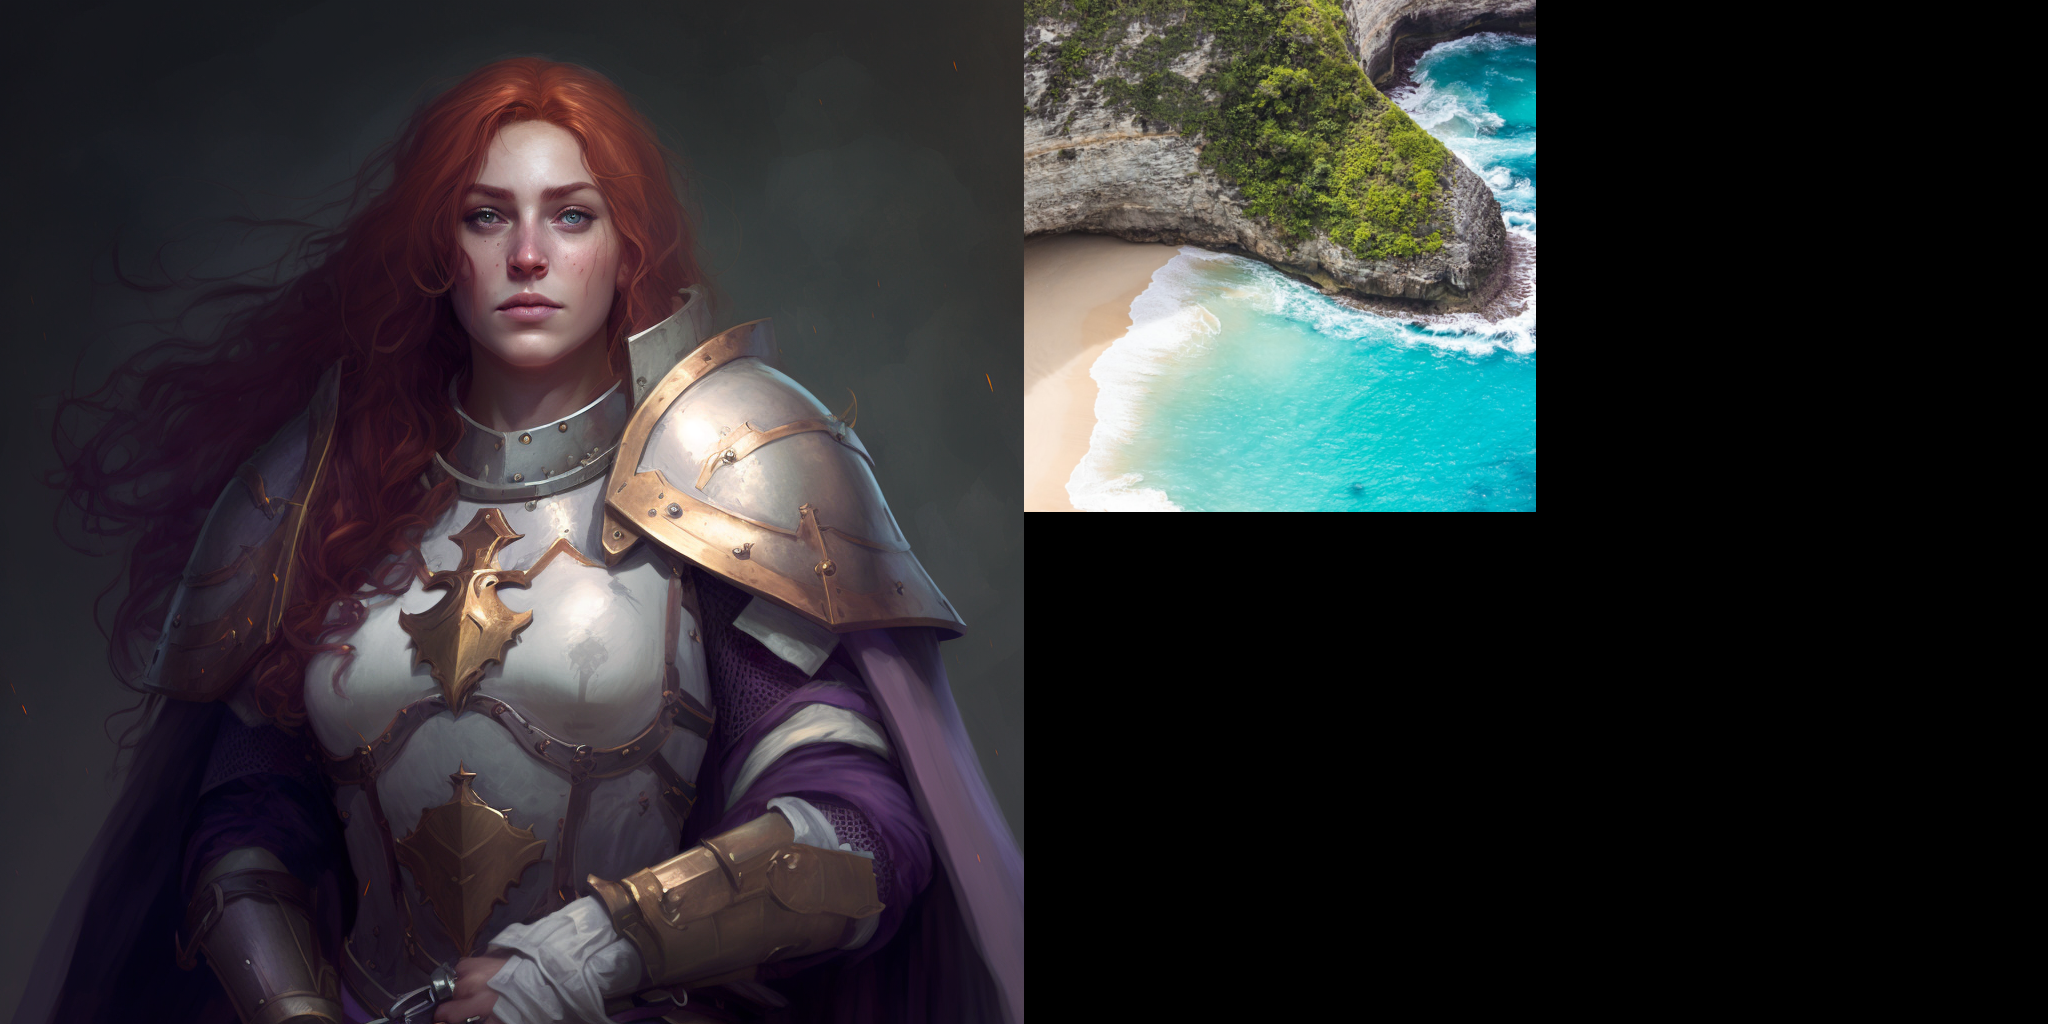

In [34]:
# read image prompt
image = Image.open("assets/images/woman.png")
image.resize((512, 512))

image2 = Image.open("assets/images/river.png")
image2.resize((512, 512))

doubleimage = [image, image2]

grid = image_grid([image, image2], 1, 2)
grid

In [35]:
# generate image variations with only image prompt
num_samples = 1
images = ip_model.generate(pil_image=doubleimage, num_samples=num_samples, num_inference_steps=20, seed=420, scale=0.5)

grid = image_grid(images, 1, 2)
grid

NameError: name 'ip_model' is not defined

In [37]:
# multimodal prompts
images = ip_model.generate(pil_image=image, num_samples=num_samples, num_inference_steps=30, seed=420,
        prompt="best quality, high quality, wearing sunglasses on the beach", scale=0.6)
grid = image_grid(images, 1, num_samples)
grid

NameError: name 'ip_model' is not defined

In [43]:
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
from diffusers import AutoPipelineForText2Image, DDIMScheduler
from transformers import CLIPVisionModelWithProjection
from diffusers.utils import load_image
import ip_adapter

image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "h94/IP-Adapter",
    subfolder="models/image_encoder",
    torch_dtype=torch.float16,
)

pipeline = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    image_encoder=image_encoder
)

# pipeline.scheduler = DDIMScheduler.from_config(pipeline.load_ip_adapterscheduler.config)

pipeline.load_ip_adapter(
  "h94/IP-Adapter",
  subfolder="sdxl_models",
  weight_name=["ip-adapter-plus_sdxl_vit-h.safetensors", "ip-adapter-plus_sdxl_vit-h.safetensors"]
)




Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]


100%|██████████| 30/30 [00:10<00:00,  3.00it/s]


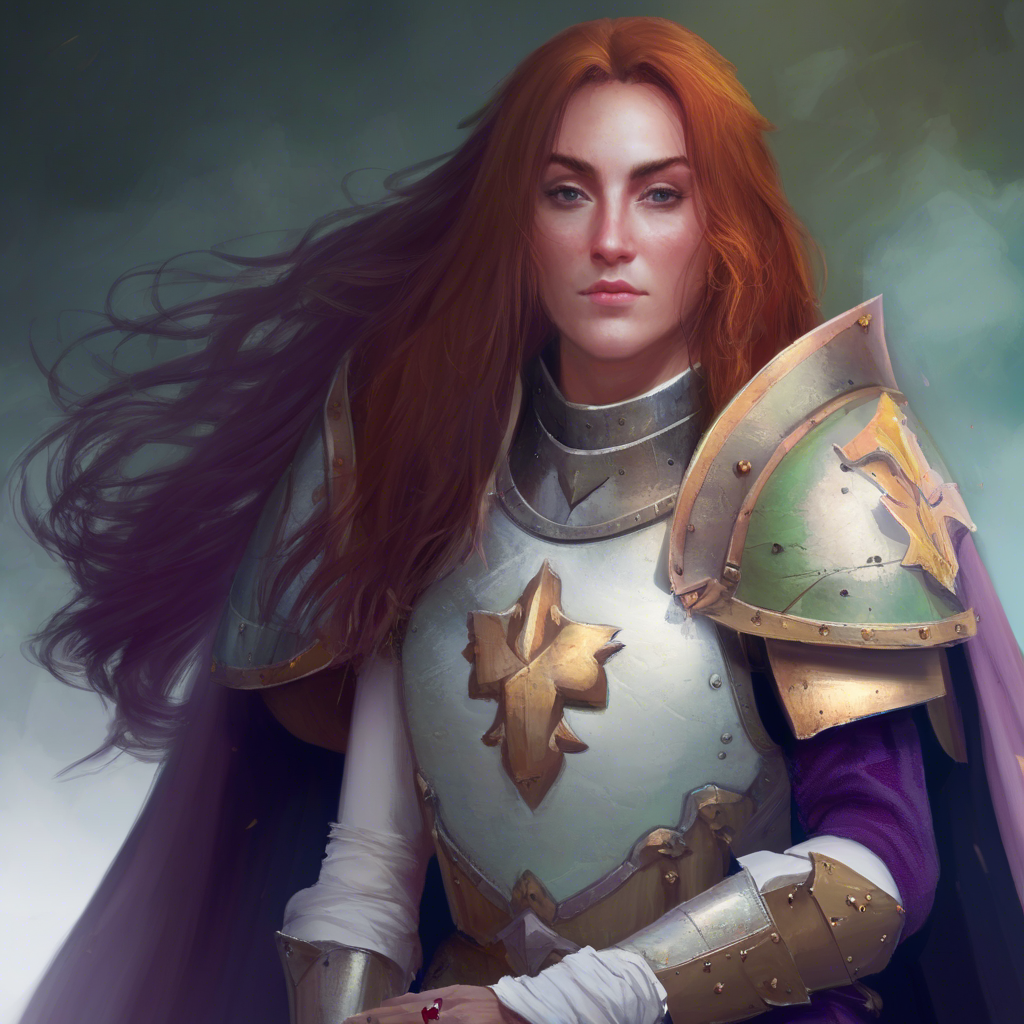

In [53]:
pipeline.set_ip_adapter_scale([0.5, # la madame
                               0.5]) # la riviere
pipeline.enable_model_cpu_offload()


image = Image.open("assets/images/woman.png")
image.resize((512, 512))

image2 = Image.open("assets/images/river.png")
image2.resize((512, 512))



generator = torch.Generator(device="cuda").manual_seed(0)

image = pipeline(
    prompt="masterpiece, best quality",
    ip_adapter_image=[image, image2],
    negative_prompt="monochrome, lowres, bad anatomy, worst quality, low quality",
    num_inference_steps=30, num_images_per_prompt=1,
    generator=generator,
).images[0]
image